
# Space

In [1]:
import os
import sys 
import logging
import pandas as pd 
from pprint import pprint 

# WorkSpace
KEY = 'WorkSpace'; WORKSPACE_PATH = os.getcwd().split(KEY)[0] + KEY; print(WORKSPACE_PATH)
os.chdir(WORKSPACE_PATH)
sys.path.append(WORKSPACE_PATH)

# Pipeline Space
from proj_space import SPACE
SPACE['WORKSPACE_PATH'] = WORKSPACE_PATH
sys.path.append(SPACE['CODE_FN'])
# pprint(SPACE)

# Available Packages
import pandas as pd
from datetime import datetime 

logger = logging.getLogger(__name__)
recfldtkn_config_path = os.path.join(SPACE['CODE_FN'], 'config_recfldtkn/')

import datasets
from recfldtkn.loadtools import load_ds_rec_and_info
from recfldtkn.configfn import load_cohort_args, load_record_args
from config_observer.CKPD import ckpd_to_CkpdObsConfig


cohort_config = load_cohort_args(recfldtkn_config_path, SPACE)
cohort_config['ckpd_to_CkpdObsConfig'] = ckpd_to_CkpdObsConfig
cohort_config['ObsDTName'] = 'ObsDT'
cohort_config['PID_ObsDT_columns'] = [cohort_config['RootID'], cohort_config['ObsDTName']]
print(cohort_config)

g:\Shared drives\CDHAI-WellDoc\2024-WellDocTest-SPACE\_WellDoc-AI-CGMGPT-WorkSpace
{'CohortInfo': {'RawData2022_CGM': {'cohort_label': 1, 'cohort_name': 'RawData2022_CGM', 'FolderPath': '../_Data/0-Data_Raw/RawData2022_CGM/'}, 'RawData2023_CVSTDCAug': {'cohort_label': 2, 'cohort_name': 'RawData2023_CVSTDCAug', 'FolderPath': '../_Data/0-Data_Raw/RawData2023_CVSTDCAug/'}, 'RawData2023_CVSDeRxAug': {'cohort_label': 3, 'cohort_name': 'RawData2023_CVSDeRxAug', 'FolderPath': '../_Data/0-Data_Raw/RawData2023_CVSDeRxAug/'}}, 'RawRootID': 'PatientID', 'RootID': 'PID', 'RecName': 'PRawRecNum', 'recattr_pyfolder': '../pipeline/fn_recattr/', 'fldtkn_pyfolder': '../pipeline/fn_fldtkn/', 'humanrec_pyfolder': '../pipeline/fn_humanrec/', 'inference_pyfolder': '../pipeline/fn_inference/', 'trigger_pyfolder': '../pipeline/fn_trigger/', 'RecName_to_RFT_GROUP_SIZE': {'CGM5Min': 100, 'Default': 5000}, 'RecName_to_RFT_idx_group_size': {'CGM5Min': 100, 'BGManual': 100, 'Default': 10000}, 'RecName_to_RFT_useb

# DfCase

In [2]:
# 0. ************ RFT config ************
RecName_to_dsRec, RecName_to_dsRecInfo = {}, {}
cohort_label_list = [1, 2, 3]

# 1. ************ Case Trigger config ************
TriggerCaseMethod = 'CGM5MinEntry'


# 2. ************ InputCaseSetName ************
# option 1
# InputCaseSetName = 'C1.2.3-CGM5MinEntry'
# InputCaseSetName = 'sftcgmbf24haf2h-rs42-ds0.1-out0.1tstail0.1vd0.1'
InputCaseSetName = None 

In [3]:
from recfldtkn.loadtools import fetch_trigger_tools

Trigger_Tools = fetch_trigger_tools(TriggerCaseMethod, SPACE)
case_id_columns = Trigger_Tools['case_id_columns']
cohort_config['case_id_columns'] = case_id_columns
case_id_columns

['PID', 'ObsDT']

In [4]:
from recfldtkn.pipeline_case import get_ds_case_to_process


InputCaseSetName, df_case = get_ds_case_to_process(InputCaseSetName, 
                                                   cohort_label_list, 
                                                   TriggerCaseMethod, 
                                                   cohort_config, 
                                                   SPACE, 
                                                   RecName_to_dsRec, 
                                                   RecName_to_dsRecInfo)

logger.info(f'InputCaseSetName: {InputCaseSetName}')
logger.info(f'df_case shape: {df_case.shape}')

[INFO:2024-04-21 09:12:33,983:(3122056948.py@12 __main__)]: InputCaseSetName: C1.2.3-CGM5MinEntry-sz21215912
[INFO:2024-04-21 09:12:33,983:(3122056948.py@13 __main__)]: df_case shape: (21215912, 2)


In [5]:
# #####################
df_case = df_case.sample(1000, random_state=42)
# #####################
df_case

,PID,ObsDT
5821055,1000995,2021-08-12 14:15:00
12271270,1002616,2021-10-02 12:20:00
15600291,1003657,2021-10-01 06:35:00
11404502,1002335,2021-09-06 04:25:00
7092362,1001275,2021-08-25 12:30:00
...,...,...
16920447,1004372,2021-12-09 13:05:00
17768177,2000224,2022-03-16 06:35:00
18638203,2001257,2022-06-10 01:55:00
3100764,1000620,2021-10-26 20:20:00


# Step 1. PttBasicWD

In [6]:
InfoRecName = 'P'
ds_info, _ = load_ds_rec_and_info(InfoRecName, cohort_config, cohort_label_list)
ds_info.column_names

['PID',
 'PatientID',
 'YearOfBirth',
 'ActivationDate',
 'MRSegmentModifiedDateTime',
 'UserTimeZone',
 'UserTimeZoneOffset',
 'Gender',
 'MRSegmentID',
 'DiseaseType']

In [7]:
##################################
TagMethod = 'PttBasicWD'
##################################

import inspect

InfoRecName = 'P'
subgroup_columns = ['Gender', 'YearOfBirth', 'DiseaseType']

def fn_case_tagging(df_case, ds_info, subgroup_columns, base_config):
    RootID = base_config['RootID']
    ds_info = ds_info.select_columns([RootID] + subgroup_columns)
    df_info = ds_info.to_pandas()
    df_info['cohort'] = df_info[RootID].apply(lambda x: 'C' + str(x)[:-base_config['RootIDLength']])
    # df_info.head()
    final_columns = [RootID] + subgroup_columns + ['cohort']

    df_case = pd.merge(df_case, df_info[final_columns], how = 'left')
    df_case['Age'] = df_case['ObsDT'].dt.year - df_case['YearOfBirth']
    return df_case

fn_case_tagging.fn_string = inspect.getsource(fn_case_tagging)

In [8]:
from recfldtkn.loadtools import convert_variables_to_pystirng, load_module_variables

prefix = ['import pandas as pd', 'import numpy as np']
string_variables = [InfoRecName]
iterative_variables = [subgroup_columns]
fn_variables = [fn_case_tagging]
pycode = convert_variables_to_pystirng(string_variables = string_variables, 
                                       iterative_variables = iterative_variables, 
                                       fn_variables = fn_variables, prefix = prefix)
pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagMethod}.py')
print(pypath)
if not os.path.exists(os.path.dirname(pypath)): os.makedirs(os.path.dirname(pypath))
with open(pypath, 'w') as file: file.write(pycode)

../pipeline\fn_learning\PttBasicWD.py


In [9]:
# pypath = os.path.join(SPACE['CODE_FN'], 'fn_learning', f'{TagMethod}.py')
# module = load_module_variables(pypath)
# InfoRecName = module.InfoRecName
# subgroup_columns = module.subgroup_columns
# fn_case_tagging = module.fn_case_tagging

In [10]:
ds_info, _ = load_ds_rec_and_info(InfoRecName, cohort_config, cohort_label_list)
df_case = fn_case_tagging(df_case, ds_info, subgroup_columns, cohort_config)
df_case

,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age
0,1000995,2021-08-12 14:15:00,2,1945,2,C1,76
1,1002616,2021-10-02 12:20:00,2,1979,1,C1,42
2,1003657,2021-10-01 06:35:00,2,1941,2,C1,80
3,1002335,2021-09-06 04:25:00,1,1950,2,C1,71
4,1001275,2021-08-25 12:30:00,1,1985,1,C1,36
...,...,...,...,...,...,...,...
995,1004372,2021-12-09 13:05:00,1,1954,1,C1,67
996,2000224,2022-03-16 06:35:00,1,1977,2,C2,45
997,2001257,2022-06-10 01:55:00,2,1963,2,C2,59
998,1000620,2021-10-26 20:20:00,1,1983,1,C1,38


In [11]:
series_time = df_case['ObsDT']
print(series_time.min(), series_time.max())

2020-12-17 14:30:00 2023-08-21 08:55:00


In [12]:
df_case['Age'].fillna('Missing').value_counts().sort_index()

Age
7     2
8     2
10    5
12    1
13    3
     ..
80    3
81    1
83    3
84    6
85    5
Name: count, Length: 72, dtype: int64

<Axes: xlabel='Age'>

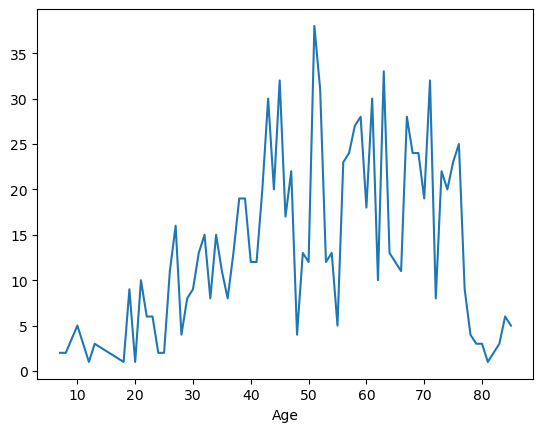

In [13]:
df_case['Age'].value_counts().sort_index().plot()#.reset_index()#.plot()

## Step 2. CFQ_Config

In [15]:
from config_observer.QCF import cf_to_QueryCaseFeatConfig

In [16]:
CFQ_TaggingList = [ 
    'Bf1mMEDALcf', 
    'Bf24hCGMrn', 
]

In [17]:
from recfldtkn.pipeline_case import process_df_tagging_tasks_in_chunks

CASE_TAGGING_PROC_CONFIG = {
    'use_CF_from_disk': False,
    'use_CO_from_disk': False,
    'start_chunk_id': 0,
    'end_chunk_id': None,
    'chunk_size': 500000,
    'save_to_pickle': False,
    'num_processors': 1
}

TagMethod_List = CFQ_TaggingList
OutputCaseSetName, df_case = process_df_tagging_tasks_in_chunks(df_case, cohort_label_list, case_id_columns, 
                                                                InputCaseSetName, 
                                                                TagMethod_List, cf_to_QueryCaseFeatConfig, 
                                                                cohort_config, SPACE, 
                                                                RecName_to_dsRec, RecName_to_dsRecInfo,
                                                                **CASE_TAGGING_PROC_CONFIG)



df_case

[INFO:2024-04-21 09:12:51,062:(pipeline_case.py@420 recfldtkn.pipeline_case)]: chunk_id_list: range(0, 1)
[INFO:2024-04-21 09:12:52,724:(loadtools.py@156 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT\3-RawData2023_CVSDeRxAug\ImpMed_data ...
[INFO:2024-04-21 09:12:53,054:(loadtools.py@156 recfldtkn.loadtools)]: No such folder: ../_Data/1-Data_RFT\1-RawData2022_CGM\LessonProg_data ...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[INFO:2024-04-21 09:13:08,110:(pipeline_case.py@462 recfldtkn.pipeline_case)]: chunk_id: 0, df_case_chunk_tagged: (1000, 21)


,PID,ObsDT,Gender,YearOfBirth,DiseaseType,cohort,Age,Bf1mMedPres:recnum,Bf1mMedAdmin:recnum,Bf1mImpMed:recnum,...,Bf1mLesson:recnum,Bf1mFood:recnum,Bf1mCarb:recnum,Bf1mExercise:recnum,Bf1mSleep:recnum,Bf1mStep:recnum,Bf1mBP:recnum,Bf1mWeigh:recnum,Bf1mLabTest:recnum,Bf24hCGMrn:recnum
0,1000009,2021-07-11 15:10:00,2,1975,2,C1,46,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0
1,1000009,2021-08-12 07:25:00,2,1975,2,C1,46,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0
2,1000009,2021-11-06 05:45:00,2,1975,2,C1,46,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,237.0
3,1000016,2021-01-28 09:10:00,1,1964,2,C1,57,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.0
4,1000016,2021-08-22 06:25:00,1,1964,2,C1,57,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3000031,2023-08-11 18:55:00,2,1990,2,C3,33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0
996,3000039,2023-06-23 14:45:00,1,1966,2,C3,57,0.0,0.0,0.0,...,0.0,150.0,87.0,92.0,0.0,30.0,0.0,0.0,0.0,273.0
997,3000039,2023-08-17 00:10:00,1,1966,2,C3,57,0.0,0.0,0.0,...,0.0,80.0,57.0,63.0,0.0,32.0,0.0,1.0,0.0,288.0
998,3000040,2023-05-04 10:50:00,2,1965,2,C3,58,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0
